In [14]:
import tensorflow
# import opencv
import matplotlib

In [15]:
# ! pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [16]:
# Import standard libraries
import cv2
import os
import numpy as np 
import random
import matplotlib.pyplot as plt

In [17]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [18]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [19]:
# # Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [20]:
# # Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [21]:
# # Uncompress Tar GZ labelled Faces in the Wild dataset
# !tar -xf lfw.tgz

In [22]:
# # Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [23]:
import uuid

In [24]:
uuid.uuid1()

UUID('c9370a14-4d11-11ef-8a97-0a76b2e55607')

In [25]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()

#     # Cut to 250x250
#     frame = frame[510:510+250, 850:850+250,:]

#     # Collect anchors
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)

#     # Collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)

#     # Show image back to screen
#     cv2.imshow('Image Collection',frame)

#     # Breaking
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break

# # Release the webcam
# cap.release()
# # CLose the image show frame 
# cv2.destroyAllWindows()

In [26]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [27]:
dir_test = anchor.as_numpy_iterator()

In [28]:
dir_test.next()

b'data/anchor/8c509178-4ce5-11ef-aabd-0a76b2e55607.jpg'

In [29]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [30]:
img = preprocess('data/anchor/1f89beba-4ce6-11ef-aabd-0a76b2e55607.jpg')
print(img.numpy().max())

1.0


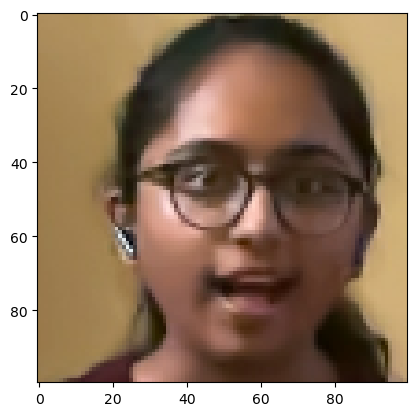

In [31]:
plt.imshow(img)

In [32]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [33]:
samples = data.as_numpy_iterator()

In [34]:
example = samples.next()
example

(b'data/anchor/c21589c6-4ce5-11ef-aabd-0a76b2e55607.jpg',
 b'data/positive/04e2e748-4ce7-11ef-aabd-0a76b2e55607.jpg',
 1.0)

In [35]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

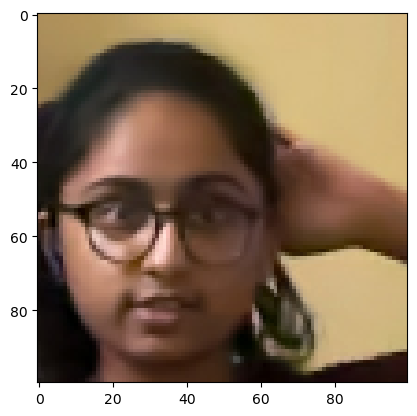

In [36]:
res = preprocess_twin(*example)
plt.imshow(res[1])

In [37]:
res[2]

1.0

In [38]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [39]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [40]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [41]:
def make_embedding():

    inp = Input(shape=(100,100,3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(128, (2,2), padding='same')(c2)

    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    

    return Model(inputs=[inp] ,outputs= [d1],name= 'embedding')

In [42]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding, dtype=tf.float32)
        validation_embedding = tf.convert_to_tensor(validation_embedding, dtype=tf.float32)
        distance = tf.math.abs(input_embedding - validation_embedding)
        return tf.squeeze(distance, axis=0)  # Remove the singleton dimension

In [44]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [45]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [47]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [49]:
test_batch = train_data.as_numpy_iterator()

In [50]:
batch_1 = test_batch.next()

In [51]:
batch_1[2]

array([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [52]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2] 

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)

    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss


In [57]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [60]:
EPOCHS = 50

In [61]:
train(train_data, EPOCHS)


 Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepst

2024-07-29 00:22:52.324209: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━

2024-07-29 00:28:21.310883: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━

2024-07-29 00:39:53.050475: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━

2024-07-29 01:03:05.141731: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━

2024-07-29 01:38:34.381354: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━

2024-07-29 02:46:51.056857: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
test_var = test_data.as_numpy_iterator().next()

In [ ]:
# Post processing the results 
y_hat = siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1]

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1.0 1.0


(4, 100, 100, 3)


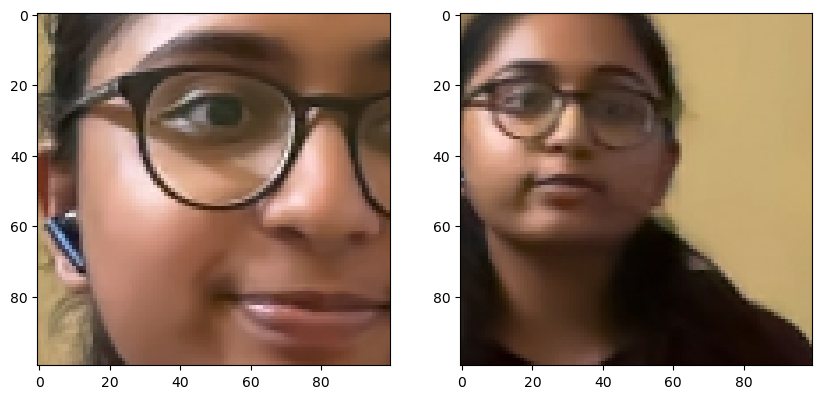

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
print(test_input.shape)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [ ]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


array([[1.00000000e+00],
       [5.49851466e-05],
       [6.21863880e-11],
       [1.21790035e-04]], dtype=float32)

In [ ]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

['c4f4fb44-4ce6-11ef-aabd-0a76b2e55607.jpg',
 '0ad8f99e-4ce7-11ef-aabd-0a76b2e55607.jpg',
 'c42844f0-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'c32b2450-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'c311048a-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'f7ecced2-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'f630fcbc-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'c45c2a0e-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'c24627ec-4ce6-11ef-aabd-0a76b2e55607.jpg',
 '0c23d350-4ce7-11ef-aabd-0a76b2e55607.jpg',
 'c1615d7e-4ce6-11ef-aabd-0a76b2e55607.jpg',
 '0aa67050-4ce7-11ef-aabd-0a76b2e55607.jpg',
 '00c53724-4ce7-11ef-aabd-0a76b2e55607.jpg',
 'c1465f74-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'c07c6156-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'f950dac0-4ce6-11ef-aabd-0a76b2e55607.jpg',
 '0bbe1786-4ce7-11ef-aabd-0a76b2e55607.jpg',
 '0b8b7100-4ce7-11ef-aabd-0a76b2e55607.jpg',
 '0a0d35c0-4ce7-11ef-aabd-0a76b2e55607.jpg',
 'f66f0930-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'c0162382-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'dfa4e058-4ce6-11ef-aabd-0a76b2e55607.jpg',
 'f6eedb4c

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/c4f4fb44-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/0ad8f99e-4ce7-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/c42844f0-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/c32b2450-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/c311048a-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/f7ecced2-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/f630fcbc-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/c45c2a0e-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/c24627ec-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/0c23d350-4ce7-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/c1615d7e-4ce6-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/0aa67050-4ce7-11ef-aabd-0a76b2e55607.jpg
application_data/verification_images/00c53724-4ce7-11ef-aabd-0a7

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[510:510+250,850:850+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(1) & 0xFF == ord('v'):
        
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

In [ ]:
np.sum(np.squeeze(results) > 0.9)

41